In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
!pip install yfinance

  Using cached yfinance-0.2.38-py2.py3-none-any.whl.metadata (11 kB)
  Using cached multitasking-0.0.11-py3-none-any.whl.metadata (5.5 kB)
  Using cached peewee-3.17.3.tar.gz (3.0 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 697.8 kB/s eta 0:00:00a 0:00:01
  Created wheel for peewee: filename=peewee-3.17.3-cp310-cp310-linux_x86_64.whl size=293152 sha256=94a4e1b40c44f4df18caa34c2305ef8467aa96f930c967980ae855fa7b4927ca
  Stored in directory: /root/.cache/pip/wheels/0d/32/b7/cad9f818b37cf97df4c87a8308da86a433af81651d98f8d8aa
Successfully built peewee


In [6]:
# Importing necessary libraries
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import matplotlib.pyplot as plt

In [7]:
# Download stock market data from Yahoo Finance
data = yf.download('AAPL', start='2010-01-01', end='2020-01-01')

[*********************100%%**********************]  1 of 1 completed


In [8]:
# Preprocessing the data
scaler = MinMaxScaler(feature_range=(-1, 1))
data['Scaled_Close'] = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [9]:
# Splitting the dataset into training and testing sets
training_data = data.iloc[:2000]['Scaled_Close'].values
testing_data = data.iloc[2000:]['Scaled_Close'].values

In [10]:
# Creating the input sequences for the LSTM model
def create_sequences(data, seq_length):
    X, Y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        Y.append(data[i+seq_length])
    return np.array(X), np.array(Y)


In [11]:
seq_length = 10
X_train, y_train = create_sequences(training_data, seq_length)
X_test, y_test = create_sequences(testing_data, seq_length)

In [12]:
# Creating the LSTM model using PyTorch
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
        torch.zeros(1,1,self.hidden_layer_size))
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [13]:
# Instantiating the LSTM model and defining the loss function and optimizer
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
# Training the LSTM model
epochs = 20
for i in range(epochs):
    for seq, labels in zip(X_train, y_train):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
        torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(torch.tensor(seq).float())
        single_loss = loss_function(y_pred, torch.tensor([labels]).float())
        single_loss.backward()
        optimizer.step()

In [16]:
# Testing the LSTM model
test_predictions = []
model.eval()
for i in range(len(X_test)):
    
    with torch.no_grad():
        test_seq = torch.tensor(X_test[i]).float()
        test_predictions.append(model(test_seq).item())

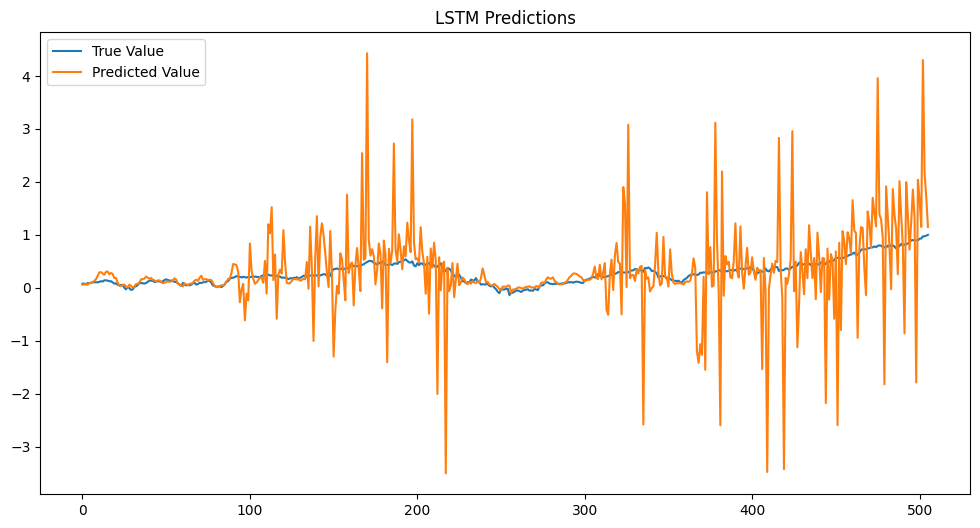

In [17]:
# Visualizing the results
plt.figure(figsize=(12,6))
plt.plot(y_test, label='True Value')
plt.plot(test_predictions, label='Predicted Value')
plt.title('LSTM Predictions')
plt.legend()
plt.show()